## Modelling, Simulation and Optimisation
### Jason Payne
Continuous Assessment 1 (x20185430)

#### Problem Definition
There are 7 wind turbines, which all need to be maintained once during the week. There are two maintenance teams: maintenance team 1 and maintenance team 2. There is no difference between the two maintenance teams.  The maintenance teams only work on workdays, i.e. from Monday to Friday. It takes one maintenance team a full day to maintain one wind turbine. Due to different locations of each wind turbine and the weather of the date, the maintenance costs are different. The costs are stated in Table 1. The costs are the same for both maintenance teams.

**Maintenance costs (10³ EUR) of different wind turbines on different days**

|Turbine|Mon|Tues|Wed|Thu|Fri|
|-------|---|----|---|---|---|
|1|10|11|12|13|14|
|2|12|14|16|18|20|
|3|17|18|17|18|17|
|4|20|19|18|17|16|
|5|22|22|22|22|33|
|6|24|23|22|23|23|
|7|9|6|8|7|9|


In [1]:
import pulp # Integer programming solver PuLP
from itertools import compress # for vector compress / formatting
import numpy as np
import random as random
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

### Part 1.1
Formulate an integer linear model to minimize the maintenance cost.

In [2]:
# How many turbines are there?
turbine_count = 7

# How many times does each turbine require maintenance?
maints_per_wk = 1

# Define the number of maintenance teams available
m_teams = 2

# Days of the week that maintenance is required
days_abb = ['mon', 'tue', 'wed', 'thu', 'fri']

In [3]:
# Use the maintenance costs as defined in the question
# Convert to numpy array so that constraints
costs_matrix = np.array([[10, 11, 12, 13, 14], 
                         [12, 14, 16, 18, 20],
                         [17, 18, 17, 18, 17],
                         [20, 19, 18, 17, 16],
                         [22, 22, 22, 22, 33],
                         [24, 23, 22, 23, 23],
                         [9, 6, 8, 7, 9]])

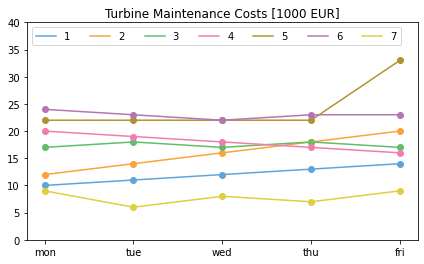

In [4]:
# Plot the cost data
colors = ['#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0', '#B2912F', '#B276B2', '#DECF3F']
fig, ax = plt.subplots(figsize = (7, 4))
for t in range(7):    
    plt.plot(days_abb, costs_matrix[t,:], color=colors[t], label=t+1)
    plt.scatter(days_abb, costs_matrix[t,:], color=colors[t])

plt.legend(loc = 'upper left', ncol=len(colors))
plt.ylim([0, 40])
plt.title('Turbine Maintenance Costs [1000 EUR]')
plt.show()

In [5]:
# Create a function for the integer linear model
def integer_model(turbine_count, days_abb, costs_matrix, m_teams, maints_per_wk):
    
    # Add problem definition
    wtm_sc = pulp.LpProblem('Turbines', pulp.LpMaximize)
    
    """ 
    Maintenance on a day for a given turbine is either 1 or 0
    e.g., w1_mon = 1 means turbine 1 is maintened on a Monday.
    Programmatically create a series of the following variable defintions 
    w1_mon = pulp.LpVariable("w1_mon", lowBound = 0, upBound = 1, cat='Integer')
    """
    for i in range(1, turbine_count+1):
        for day in days_abb:
            def_str = 'w' + str(i) + '_' + day
            globals()[def_str] = pulp.LpVariable(def_str, lowBound = 0, upBound = 1, cat = 'Integer') 
    
    # Prepare the utility function programmatically
    # Create a matrix of objects for the turbine maintenance on a given day
    # Initialize empty
    mains_matrix = np.empty(shape = (turbine_count, len(days_abb)), dtype = 'object')

    # Now populate with the variable objects
    for row in range(mains_matrix.shape[0]):
        for col in range(mains_matrix.shape[1]):
            mains_matrix[row, col] = globals()['w' + str(row+1) + '_' + days_abb[col]]
    
    # This will be the sum of day cost * the turbine-day bolean var
    # Costs taken from costs matrix
    for row in range(turbine_count):
        if row == 0:
            vec = sum(mains_matrix[row, :] * costs_matrix[row, :])  
        else:
            vec_add = sum(mains_matrix[row, :] * costs_matrix[row, :])
            vec = vec + vec_add   

    # Negate as we want to minimise the cost
    wtm_sc += -1*(vec)

    """
    Define Constraints
    Each turbine must be maintained only n times per week (maints_per_wk)
    Programmatically create the following constraint equations for each turbine 
    wtm_sc += w1_mon + w1_tue + w1_wed + w1_thu + w1_fri == maints_per_wk
    """
    for turbine in range(turbine_count):
        wtm_sc += sum(mains_matrix[turbine, ]) == maints_per_wk

    """
    Only m maintenance teams are available each day
    Programmatically create the following constraint equations for each turbine
    wtm_sc += w1_mon + w2_mon + w3_mon + ... + wn_mon <= m_teams
    """
    for day in range(len(days_abb)):
        wtm_sc += sum(mains_matrix[:, day]) <= m_teams
    
    # Create a matrix of objects for the turbine maintenance on a given day
    # Initialize empty
    mains_matrix = np.empty(shape = (turbine_count, len(days_abb)), dtype = 'object')
    
    # Now populate with the objects
    for row in range(mains_matrix.shape[0]):
        for col in range(mains_matrix.shape[1]):
            mains_matrix[row, col] = globals()['w' + str(row+1) + '_' + days_abb[col]]
    
    return(wtm_sc, mains_matrix)

In [6]:
# Now create the model using the function for the 7-turbine case
wtm, mains_matrix = integer_model(
    turbine_count = 7, 
    days_abb = ['mon', 'tue', 'wed', 'thu', 'fri'],
    costs_matrix = costs_matrix,
    m_teams = 2, 
    maints_per_wk = 1
)

In [7]:
# Print a summary of the model
print(wtm)

Turbines:
MAXIMIZE
-14*w1_fri + -10*w1_mon + -13*w1_thu + -11*w1_tue + -12*w1_wed + -20*w2_fri + -12*w2_mon + -18*w2_thu + -14*w2_tue + -16*w2_wed + -17*w3_fri + -17*w3_mon + -18*w3_thu + -18*w3_tue + -17*w3_wed + -16*w4_fri + -20*w4_mon + -17*w4_thu + -19*w4_tue + -18*w4_wed + -33*w5_fri + -22*w5_mon + -22*w5_thu + -22*w5_tue + -22*w5_wed + -23*w6_fri + -24*w6_mon + -23*w6_thu + -23*w6_tue + -22*w6_wed + -9*w7_fri + -9*w7_mon + -7*w7_thu + -6*w7_tue + -8*w7_wed + 0
SUBJECT TO
_C1: w1_fri + w1_mon + w1_thu + w1_tue + w1_wed = 1

_C2: w2_fri + w2_mon + w2_thu + w2_tue + w2_wed = 1

_C3: w3_fri + w3_mon + w3_thu + w3_tue + w3_wed = 1

_C4: w4_fri + w4_mon + w4_thu + w4_tue + w4_wed = 1

_C5: w5_fri + w5_mon + w5_thu + w5_tue + w5_wed = 1

_C6: w6_fri + w6_mon + w6_thu + w6_tue + w6_wed = 1

_C7: w7_fri + w7_mon + w7_thu + w7_tue + w7_wed = 1

_C8: w1_mon + w2_mon + w3_mon + w4_mon + w5_mon + w6_mon + w7_mon <= 2

_C9: w1_tue + w2_tue + w3_tue + w4_tue + w5_tue + w6_tue + w7_tue <= 2

_C1

### Part 1.2
Solve the problem by means of a standard LP or IP solver (like PuLP).

In [8]:
# Solve the problem using the integer programming solver PuLP
now = datetime.now()
feasible_solution = wtm.solve() == 1
print('Runtime:', datetime.now() - now, '\n')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/fd4d394738cf46058ee7240ed788dab9-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/fd4d394738cf46058ee7240ed788dab9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 17 COLUMNS
At line 193 RHS
At line 206 BOUNDS
At line 242 ENDATA
Problem MODEL has 12 rows, 35 columns and 70 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -105 - 0.00 seconds
Cgl0005I 7 SOS with 35 members
Cgl0004I processed model has 12 rows, 35 columns (35 integer (35 of which binary)) and 70 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solu

In [9]:
if feasible_solution:
    print('Success: Feasible optimal solution found')
    print('         No. of maintenance teams is ' + str(m_teams))
else:
    print('Fail: No feasible solution, increase number of maintenance teams...')

Success: Feasible optimal solution found
         No. of maintenance teams is 2


In [10]:
# Print the minimum maintenance cost
min_mantenance_cost = -1*pulp.value(wtm.objective)
print("Minimized maintenance cost is €" + "{:,}".format(min_mantenance_cost*1000))

Minimized maintenance cost is €105,000.0


In [11]:
# Print the maintenance days explicitly
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Create a matrix for the boolean results, i.e., maintenance on a day or not
res_matrix = np.empty(shape = (turbine_count, len(days_abb)), dtype = 'int')

# Now populate with the results of the analysis
for turbine in range(turbine_count):
    sol_vec = []
    for day in range(len(days_abb)):
        sol_vec.append(pulp.value(mains_matrix[turbine, day]))
    res_matrix[turbine, :] = sol_vec
    
# Take a look, each row is a turbin, each column is a day.
print('Maintenance matrix (W) for 7-turbine problem:\n')
print(res_matrix)

Maintenance matrix (W) for 7-turbine problem:

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]]


In [12]:
print('Maintenance day summary:\n')
for turbine in range(turbine_count):
        print('Turbine #' + str(turbine+1) + ': ' + str(list(compress(days, res_matrix[turbine, :]))))

Maintenance day summary:

Turbine #1: ['Monday']
Turbine #2: ['Monday']
Turbine #3: ['Friday']
Turbine #4: ['Friday']
Turbine #5: ['Thursday']
Turbine #6: ['Wednesday']
Turbine #7: ['Tuesday']


### Part 3.1
Generate data for a wind farm that contains 100 or more wind turbine. Choose the cost distribution function carefully and document your decision.

### Cost Data Modelling 

#### 1) Normal Distribution

In [13]:
# Define a set of bins for the cost data histogram
bins = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]

Costs sample: [10 11 12 13 14 12 14 16 18 20 17 18 17 18 17 20 19 18 17 16 22 22 22 22
 33 24 23 22 23 23  9  6  8  7  9]


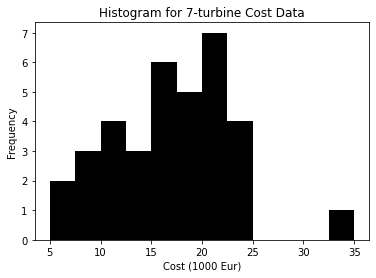

In [14]:
# Plot the 7-turbine cost data
costs_sample = np.reshape(costs_matrix, (1, 7*len(days_abb)))
costs_sample = costs_sample[0]
print('Costs sample:',costs_sample)

# plot a histogram of the sample
plt.hist(costs_sample, bins=bins, color='black')
plt.xlabel("Cost (1000 Eur)")
plt.ylabel("Frequency")
plt.title("Histogram for 7-turbine Cost Data")
plt.show()

In [15]:
# Let's check if this data could be drawn from a normal distribution
# Firstly, calculate mean & std parameters
μ = np.mean(costs_sample)
σ = np.std(costs_sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (μ, σ))

Mean=16.914, Standard Deviation=5.769


Text(0.5, 1.0, 'Normal Distribution Fitted to 7-turbine Cost Data')

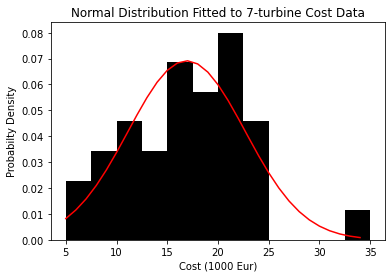

In [16]:
# Define & review a normal distribution
dist_normal = stats.norm(μ, σ)
values = [value for value in range(5, 35)]
probs_norm = [dist_normal.pdf(value) for value in values]
plt.hist(costs_sample, bins=bins, density=True, color='black')
plt.plot(values, probs_norm, color='red')
plt.xlabel("Cost (1000 Eur)")
plt.ylabel("Probabilty Density")
plt.title("Normal Distribution Fitted to 7-turbine Cost Data")

In [17]:
# Define a simple function for checking Ho 
def check_null(alpha, p_val):
    print("p = {:g}".format(p_val))
    print('Null hypothesis: x comes from a normal distribution')
    if p_val < alpha:  # null hypothesis: x comes from a normal distribution
        print("> The null hypothesis can be rejected")
    else:
        print("> The null hypothesis cannot be rejected")

In [18]:
"""
NORMAL TEST: This function tests the null hypothesis that a sample comes from a 
normal distribution. It is based on D’Agostino and Pearson’s test 
that combines skew and kurtosis to produce an omnibus test of normality.
"""
normal_test = stats.normaltest(costs_sample)
print(normal_test)
p_norm = normal_test.pvalue
check_null(alpha=1e-3, p_val=p_norm)

NormaltestResult(statistic=0.5832429497038247, pvalue=0.7470512601497533)
p = 0.747051
Null hypothesis: x comes from a normal distribution
> The null hypothesis cannot be rejected


In [19]:
"""
SHAPIRO-WILK TEST: This function tests the null hypothesis that the data was drawn 
from a normal distribution
"""
shapiro_test = stats.shapiro(costs_sample)
print(shapiro_test)
p_shapiro = shapiro_test.pvalue
check_null(alpha=1e-3, p_val=p_shapiro)

ShapiroResult(statistic=0.962090253829956, pvalue=0.263947069644928)
p = 0.263947
Null hypothesis: x comes from a normal distribution
> The null hypothesis cannot be rejected


In [20]:
"""
KS TEST: Performs the (one-sample or two-sample) Kolmogorov-Smirnov test for goodness of fit.
Perform two-sided test: The null hypothesis is that the two distributions are identical, F(x)=G(x) 
for all x; the alternative is that they are not identical.
"""
k_test = stats.kstest(costs_sample, dist_normal.cdf)
print(k_test)
p_k = k_test.pvalue
check_null(alpha=1e-3, p_val=p_k)

KstestResult(statistic=0.10592742804556088, pvalue=0.7885263672802415)
p = 0.788526
Null hypothesis: x comes from a normal distribution
> The null hypothesis cannot be rejected


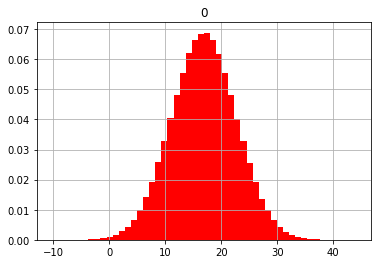

In [21]:
# Verify the created normal distribution
tdata=pd.DataFrame(dist_normal.rvs(1000000))
tdata.hist(bins=50, density=True, color='red')
plt.grid(True)

#### 2) Rayleigh Distribution

Text(0.5, 1.0, 'Rayleigh Distribution Fitted to 7-turbine Cost Data')

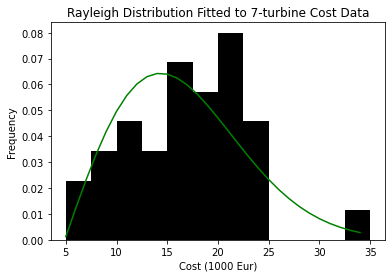

In [22]:
# Define & review a Rayleigh distribution
loc, scale = stats.rayleigh.fit(costs_sample) 
values = [value for value in range(5, 35)]
probs_ray = [stats.rayleigh(scale=scale, loc=loc).pdf(value) for value in values]
plt.hist(costs_sample, bins=bins, density=True, color='black')
plt.plot(values, probs_ray, color='green')
plt.xlabel("Cost (1000 Eur)")
plt.ylabel("Frequency")
plt.title("Rayleigh Distribution Fitted to 7-turbine Cost Data")

#### 3) Empirical Modelling

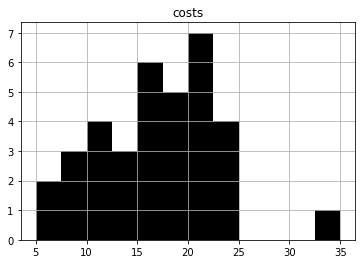

In [23]:
bins = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
df = pd.DataFrame()
df['costs'] = costs_sample
df.hist('costs', bins=bins, color = 'black')
plt.grid(True)

In [24]:
hist, _ = np.histogram(df['costs'], bins=bins)
G = [0] + (np.cumsum(hist)/np.sum(hist)).tolist()

In [25]:
def gst():
    u=random.random()
    for i in range(len(G)-1):
        if G[i]<=u and u<G[i+1]:
            return int(bins[i]+(u-G[i])*(bins[i+1]-bins[i])/(G[i+1]-G[i]))
    else:
        return int(bins[-1])

In [26]:
# Create & save data for 5 seeds (realisations)
random_seeds = [156, 265, 15, 456, 26]
for rseed in random_seeds:
    random.seed(rseed)
    gdata = pd.DataFrame([gst() for i in range(101*5)])
    costs_matrix_large = np.reshape(gdata[0].values, (101, len(days_abb)))
    np.savetxt(f'costs_matrix_large_{rseed}.csv', costs_matrix_large, delimiter=",")
    globals()[f'gdata_{rseed}'] = gdata

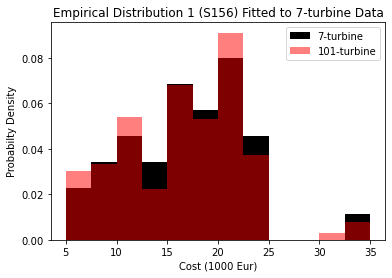

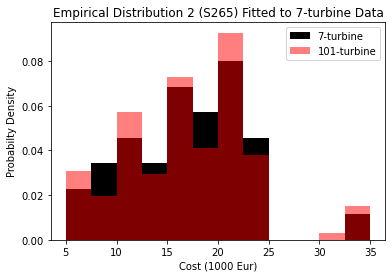

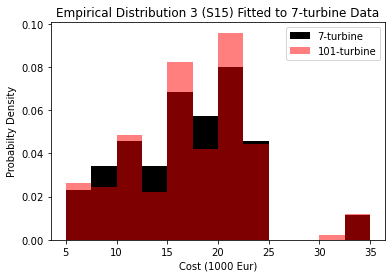

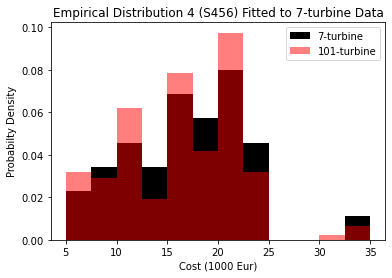

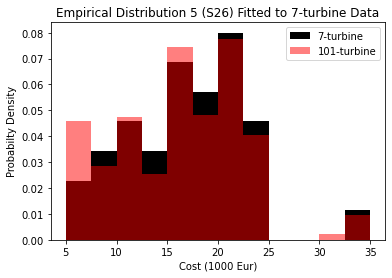

In [27]:
# Now plot each of the generated distributions verses the 7-turbine data
for count, rseed in enumerate(random_seeds):
    plt.hist(costs_sample, bins=bins, density=True, color='black', label = '7-turbine')
    plt.hist(globals()[f'gdata_{rseed}'], bins=bins, density=True, color='red', alpha=0.5, label = '101-turbine')
    plt.xlabel("Cost (1000 Eur)")
    plt.ylabel("Probabilty Density")
    plt.title(f'Empirical Distribution {count+1} (S{rseed}) Fitted to 7-turbine Data')
    plt.legend(loc = 'upper right')
    plt.show()

Generated data looks reasonable and is deemed to be a better represenatation of the scaled up 7-turbine data.  We will use this data for testing the scaled up problem.

In [28]:
# Assign the 5 distributions as variables
for c in range(1, 6, 1):
    globals()[f'costs_matrix_large_{c}'] = np.genfromtxt(f'costs_matrix_large_{random_seeds[c-1]}.csv', delimiter=',')

### Part 3.2
Use the standard solver for LP (Pulp package) to solve the larger size optimisation  problem. 

#### Integer Linear Model

In [29]:
# Run the ineger linear model for each of the 5 cost datasets & collect
# results in a vector.  Wrap in function so we can run for other team sizes.
def run_integer_model_on_all(m, save_out=False):
    minimised_costs = []

    # Print the maintenance days explicitly
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    for r in range(1, 6, 1):
        wtm_sc, mains_matrix_sc = integer_model(
            turbine_count = 101, 
            days_abb = ['mon', 'tue', 'wed', 'thu', 'fri'],
            costs_matrix = globals()[f'costs_matrix_large_{r}'],
            m_teams = m, 
            maints_per_wk = 1
        )

        # Solve the problem using the integer programming solver PuLP
        now = datetime.now()
        feasible_solution = wtm_sc.solve() == 1
        print('Runtime:', datetime.now() - now, '\n')

        minimised_costs.append(-1*pulp.value(wtm_sc.objective))

        # Create a matrix for the boolean results, i.e., maintenance on a day or not
        res_matrix_sc = np.empty(shape = (101, len(days_abb)), dtype = 'int')

        # Now populate with the results of the analysis
        for turbine in range(101):
            sol_vec = []
            for day in range(len(days_abb)):
                sol_vec.append(pulp.value(mains_matrix_sc[turbine, day]))
            res_matrix_sc[turbine, :] = sol_vec
        
        if save_out:
            # Assign some global variable for later comparison with alternative approach
            globals()[f'ip_{m}m_100t_colsums_{r}'] = sum(res_matrix_sc)    
            globals()[f'res_{m}m_matrix_sc_{r}'] = res_matrix_sc
            
    return(minimised_costs)

In [30]:
# 21 maintenance teams
ip_costs_21 = run_integer_model_on_all(21, save_out=True)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/2586fcd562504a4e9b9b3067aa365cbf-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/2586fcd562504a4e9b9b3067aa365cbf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -962 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/c777e2472f24459ab4917ec3da82a6b9-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/c777e2472f24459ab4917ec3da82a6b9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -912 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

In [31]:
# Define a simple function for printing formatted maintenance cost
def big_cost(cost):
    f_cost = "{:,}".format(cost*1000)
    return(f'€{f_cost}')

In [32]:
print('21 Teams - Optimised Costs:')
print('===========================')
print(f'S1: {big_cost(ip_costs_21[0])} \nS2: {big_cost(ip_costs_21[1])} \nS3: {big_cost(ip_costs_21[2])}\
\nS4: {big_cost(ip_costs_21[3])} \nS5: {big_cost(ip_costs_21[4])}')

21 Teams - Optimised Costs:
S1: €962,000.0 
S2: €977,000.0 
S3: €992,000.0
S4: €966,000.0 
S5: €912,000.0


In [33]:
# 22 maintenance teams
costs_22 = run_integer_model_on_all(22, save_out=True)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/e5372ab879534d95ac3e09c3e0571993-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/e5372ab879534d95ac3e09c3e0571993-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -961 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/16ecd7f81cab4ea7b170d6d6041acb30-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/16ecd7f81cab4ea7b170d6d6041acb30-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -910 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

In [34]:
print('22 Teams - Optimised Costs:')
print('===========================')
print(f'S1: {big_cost(costs_22[0])} \nS2: {big_cost(costs_22[1])} \nS3: {big_cost(costs_22[2])}\
\nS4: {big_cost(costs_22[3])} \nS5: {big_cost(costs_22[4])}')

22 Teams - Optimised Costs:
S1: €961,000.0 
S2: €975,000.0 
S3: €990,000.0
S4: €963,000.0 
S5: €910,000.0


In [35]:
# 23 maintenance teams
costs_23 = run_integer_model_on_all(23, save_out=True)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/26527402bcfb4b6b9c153c2c3c729c15-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/26527402bcfb4b6b9c153c2c3c729c15-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -960 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/faeccfd8f96b4c7089be88b668165a3c-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/faeccfd8f96b4c7089be88b668165a3c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -910 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

In [36]:
print('23 Teams - Optimised Costs:')
print('===========================')
print(f'S1: {big_cost(costs_23[0])} \nS2: {big_cost(costs_23[1])} \nS3: {big_cost(costs_23[2])}\
\nS4: {big_cost(costs_23[3])} \nS5: {big_cost(costs_23[4])}')

23 Teams - Optimised Costs:
S1: €960,000.0 
S2: €975,000.0 
S3: €989,000.0
S4: €960,000.0 
S5: €910,000.0


In [37]:
# 24 maintenance teams
costs_24 = run_integer_model_on_all(24, save_out=True)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/4888c15c47354eb4b700d033592c2204-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/4888c15c47354eb4b700d033592c2204-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -960 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/e9ee93815576499ca708707fb76dd38b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/e9ee93815576499ca708707fb76dd38b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -910 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

In [38]:
print('24 Teams - Optimised Costs:')
print('===========================')
print(f'S1: {big_cost(costs_24[0])} \nS2: {big_cost(costs_24[1])} \nS3: {big_cost(costs_24[2])}\
\nS4: {big_cost(costs_24[3])} \nS5: {big_cost(costs_24[4])}')

24 Teams - Optimised Costs:
S1: €960,000.0 
S2: €975,000.0 
S3: €988,000.0
S4: €960,000.0 
S5: €910,000.0


In [39]:
# 25 maintenance teams
costs_25 = run_integer_model_on_all(25, save_out=True)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/1f5c4d950b284fd28ffcd29fbb13c85d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/1f5c4d950b284fd28ffcd29fbb13c85d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -960 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jasonpayne/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/e371d8585a3149c28a5c5679b73c1290-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/e371d8585a3149c28a5c5679b73c1290-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 111 COLUMNS
At line 2637 RHS
At line 2744 BOUNDS
At line 3250 ENDATA
Problem MODEL has 106 rows, 505 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -910 - 0.00 seconds
Cgl0005I 101 SOS with 505 members
Cgl0004I processed model has 106 rows, 505 columns (505 integer (505 of which binary)) and 1010 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

In [40]:
print('25 Teams - Optimised Costs:')
print('===========================')
print(f'S1: {big_cost(costs_25[0])} \nS2: {big_cost(costs_25[1])} \nS3: {big_cost(costs_25[2])}\
\nS4: {big_cost(costs_25[3])} \nS5: {big_cost(costs_25[4])}')

25 Teams - Optimised Costs:
S1: €960,000.0 
S2: €975,000.0 
S3: €988,000.0
S4: €960,000.0 
S5: €910,000.0


Results for 25 teams are the same as 24 teams, no further improvements can be made with adding extra teams.

### Part 3.3
Use the heuristic, greedy or evolutionary strategy implementation you used previously to to solve the optimisation problem with more than 100 wind turbine. 

#### Greedy Strategy

In [41]:
import random as random

In [42]:
# Simple appender function
def appender(inp, app):
    if isinstance(app, list):
        inp.extend(app)
    else:
        inp.append(app)

In [43]:
"""
METHOD 1: This method is the base-case greedy method used for the project.
========  This method was found to be marginally better than Method 2.
          Rows are selected based on lowest daily cost (without checking if the lowest
          day is actually available).  If the lowest day is unavailable, the next lowest
          day is selected for that turbine and the algorithm moves to the next.
"""
def greedy_maintenance_sm(cost_matrix, max_iters, num_of_teams, num_turbines, num_days=5, target_mins=True, debug=False, rand_select=False):
    """
    Function:
        Greedy algorithm for scheduling maintenance on wind turbines.
        Default is to schedule based on rows with lowest daily cost.
        Once a row is picked, maintenance is scheduled even if lowest daily cost
        is unavailable due to a teams constraint.
    Arguments:
        cost_matrix: Matrix of costs for each turbine on each day
        max_iters: How many (max) iterations to run for
        num_of_teams: How many teams are in the simulation
        num_turbines: How many turbines
        num_days: How many days in the week (default 5)
        target_mins: Target min rows or max rows (default min rows)
    Returns:
        not_filled_length: Number of unscheduled turbines/rows
        solution: The 1/0 matrix showing what turbines are maintained on what days  
        solution_cost: Total cost of maintenance
        missed_turbines: Number of unscheduled turbines (same as param 1 as check)

    """
    min_of_rows = cost_matrix.min(axis = 1)
    
    # Define a matrix of all zeros to store our solution as we build it
    solution = np.zeros(shape = (num_turbines, num_days), dtype=int)
    
    # Keep track of rows we schedule maintenance in...
    selected_rows = []    
    chked_cols = []
    
    # In each iteration assign maintenance to a turbine selected from a 
    # list of remaining rows with minimum daily cost options...
    for it in range(1, max_iters, 1):        
        # Identify rows/turbines not yet scheduled...
        not_filled = np.where(solution.sum(axis = 1) == 0)[0]
        not_filled_length = len(not_filled)
        if not_filled_length == 0:
            print('All turbines have been scheduled...\n')
            break
        
        # Get the min or max of these rows depending on criteria        
        if target_mins:
            min_not_filled = min(min_of_rows[not_filled])
        else:
            min_not_filled = max(min_of_rows[not_filled])
        
        # Now create a list of row options (those with lowest cost)
        new_row_opts = np.where(min_of_rows == min_not_filled)[0]        
        selected_rows.sort()
        new_row_opts = [item for item in new_row_opts if item not in selected_rows] 
        
        # Check available rows...
        no_available_rows = np.array(new_row_opts).size == 0
        if no_available_rows: 
            # We may need to clean up & assign maintenance based on available
            # days and best feasible cost option for the turbine
            print('---Sweep up missed turbines....')
            print('Unscheduled turbines:', not_filled)
            
            for unfilled in not_filled:
                chk_costs = cost_matrix[unfilled,:]          
                avail_cols = solution.sum(axis = 0) < num_of_teams  
                if sum(avail_cols) == 0: 
                    print('> No available teams...')
                    break
                # Get min cost option for available days
                chk_cost_pos = chk_costs == min(chk_costs[avail_cols])  
                fill_col = np.where(avail_cols & chk_cost_pos)[0]
                solution[unfilled, fill_col] = 1
                print('> Maintenance allocated...\n')
            print('Ending final sweep...\n')
            break
        
        # Select a turbine from the min cost options & try to schedule 
        # maintenance        
        if rand_select: # Randomly selects an option 
            random_index = random.randint(0, len(new_row_opts)-1)
            new_row = new_row_opts[random_index]
        else: # Select based on turbine with highest median day cost             
            row_selects = costs[new_row_opts,:]
            # Sort in ascending order so we can select median
            row_selects.sort()
            row_second_maxes = row_selects[:,2]
            row_second_maxes_select = np.where(row_second_maxes == max(row_second_maxes))[0]
            new_row_lis = new_row_opts
            new_row = new_row_lis[int(row_second_maxes_select[0])]   
        
        # Add the row number to our tracking list
        selected_rows.append(new_row)
        
        # Get the column number for this option & check if it is a viable option
        # We must not break the number of teams available on a given day constraint
        new_col = np.where(cost_matrix[new_row,:] == min_not_filled)[0][0] # 1st if duplicates
        
        max_of_cols = solution.sum(axis = 0)
        is_empty = np.array(np.where(np.where(max_of_cols >= num_of_teams)[0] == new_col)).size == 0
        
        if is_empty:
            # OK, schedule the maintenance
            solution[new_row, new_col] = 1            
            chked_cols = []   
        else:
            for ck in range(num_days-1):
                if debug: print(f'Check {ck+1} for turbine {new_row} due to clash...')
                appender(chked_cols, new_col)
                chked_cols = list(set(chked_cols))
                chked_cols.sort()                               

                # Get column positions excluding current column (we can't use this...)
                list_difference = [item for item in [0, 1, 2, 3, 4] if item not in chked_cols]

                # Calculate the new min exluding previous selected columns
                new_min = min(cost_matrix[new_row, list_difference])

                # There might be more than one option, so create a list
                new_min_list = np.where(cost_matrix[new_row,:] == new_min)[0]
                new_diff = [item for item in new_min_list if item not in chked_cols]
                
                # These are new options, let's check if we can schedule for these days...
                new_col_opts = new_diff

                new_col = new_col_opts[0]
                if debug: print(f'Checking day {new_col} as alternative')
                max_of_cols = solution.sum(axis = 0)
                is_empty = np.array(np.where(np.where(max_of_cols >= num_of_teams)[0] == new_col)).size == 0

                if is_empty:
                    # OK, schedule the maintenance
                    solution[new_row, new_col] = 1
                    if debug: print('> Maintenance allocated...\n')
                    chked_cols = [] 
                    break
                else:
                    if ck == num_days-2:
                        max_of_cols = solution.sum(axis = 0)
                        if debug: print('> Clash at day', new_col)
                        if debug: print('>> Skip & catch in final sweep...\n')
                        chked_cols = []
                        break
                    if debug: print('> Clash at day', new_col)
    
    # Let's summarise the results
    # ===========================
    # Calcuate the total cost of maintenance
    max_of_cols = solution.sum(axis = 0)
    solution_cost_raw = sum(sum(cost_matrix*solution))
    solution_cost = "{:,}".format(solution_cost_raw*1000) 
    
    # Check if we missed some turbines
    max_of_rows = solution.sum(axis = 1)
    missed_turbines = num_turbines - sum(max_of_rows == 1)
    if missed_turbines != 0:
        missed_turbines_warning = 'WARNING! - Try adding more teams...'
    else:
        missed_turbines_warning = '~ok!'
    
    print('Result Summary')
    print('==============')
    print(f'Solution cost is €{solution_cost}')
    print('Team requirement per day', max_of_cols)
    print('Number of maintenance teams specified:', num_of_teams)
    print('Number of missed turbines:', missed_turbines, missed_turbines_warning, '\n')
    return(not_filled_length, solution, solution_cost, solution_cost_raw, missed_turbines)                    
                    

In [44]:
"""
METHOD 2: This method was trialled but not used for the project.
========  This is a slightly simpler method that simply looks for the lowest daily
          cost day available in each iteration.  The method was found to perform
          marginally worst than Method 1 for the five large cost datasets.
"""
def greedy_maintenance_wm(cost_matrix, max_iters, num_of_teams, num_turbines, num_days=5, debug=False, rand_select=False):
    """
    Function:
        Greedy algorithm for scheduling maintenance on wind turbines.
        Default is to schedule based on lowest available cost option
        available in each iteration.
    Arguments:
        cost_matrix: Matrix of costs for each turbine on each day
        max_iters: How many (max) iterations to run for
        num_of_teams: How many teams are in the simulation
        num_turbines: How many turbines
        num_days: How many days in the week (default 5)
    Returns:
        not_filled_length: Number of unscheduled turbines/rows
        solution: The 1/0 matrix showing what turbines are maintained on what days  
        solution_cost: Total cost of maintenance
        missed_turbines: Number of unscheduled turbines (same as param 1 as check)

    """
    # Define a matrix of all zeros to store our solution as we build it
    solution = np.zeros(shape = (num_turbines, num_days), dtype=int)
       
    # Identify rows/turbines not yet scheduled...
    not_filled = np.where(solution.sum(axis = 1) == 0)[0]
    not_filled_length = len(not_filled)

    not_filled_list = list(not_filled)
    print('Turbines to allocate:', len(not_filled_list))

    while len(not_filled_list) != 0:
        avails = np.where(solution.sum(axis = 0) < num_of_teams)[0]
        costs_avails = costs[np.ix_(not_filled_list, avails)]
        costs_avails_mins = costs_avails.min(axis = 1)
        min_of_costs_avails_mins = min(costs_avails_mins)
        min_locs = np.where(costs_avails_mins == min_of_costs_avails_mins)[0]

        # Select a turbine from the min cost options & schedule maintenance        
        if rand_select: # Randomly selects an option 
            random_index = random.randint(0, len(min_locs)-1)
            new_row = min_locs[random_index]
        else: # Select based on turbine with highest median day cost             
            row_selects = costs[min_locs,:]
            # Sort in ascending order so we can select median
            row_selects.sort()
            row_second_maxes = row_selects[:,2]
            row_second_maxes_select = np.where(row_second_maxes == max(row_second_maxes))[0]
            new_row_lis = min_locs
            new_row = new_row_lis[int(row_second_maxes_select[0])]

        row_loc = not_filled_list[min_locs[0]]
        row_loc = not_filled_list[new_row]
        col_loc_ops = np.where(costs[row_loc,:] == min_of_costs_avails_mins)[0]
        col_loc_ops = [item for item in col_loc_ops if item in avails]
        col_loc = col_loc_ops[0]

        solution[row_loc, col_loc] = 1
        arr_not_filled_list = np.array(not_filled_list)
        ind_pop = np.where(arr_not_filled_list == row_loc)[0][0]
        
        if len(not_filled_list) != 0:
            not_filled_list.pop(ind_pop)
            
    print('> All assigned...')
    
    # Let's summarise the results
    # ===========================
    # Calcuate the total cost of maintenance
    max_of_cols = solution.sum(axis = 0)
    solution_cost_raw = sum(sum(cost_matrix*solution))
    solution_cost = "{:,}".format(solution_cost_raw*1000) 
    
    # Check if we missed some turbines
    max_of_rows = solution.sum(axis = 1)
    missed_turbines = num_turbines - sum(max_of_rows == 1)
    if missed_turbines != 0:
        missed_turbines_warning = 'WARNING! - Try adding more teams...'
    else:
        missed_turbines_warning = '~ok!'
    
    print('\nResult Summary')
    print('==============')
    print(f'Solution cost is €{solution_cost}')
    print('Team requirement per day', max_of_cols)
    print('Number of maintenance teams specified:', num_of_teams)
    print('Number of missed turbines:', missed_turbines, missed_turbines_warning, '\n')
    return(not_filled_length, solution, solution_cost, solution_cost_raw, missed_turbines)                    
                    

In [45]:
# Run the Greedy Algorithm for the 5 cost datasets
# Use the minimum feasible team count (21) to start with
gr_maint_costs_21 = []
for f in range(1, 6, 1):
    costs = globals()[f'costs_matrix_large_{f}']
    not_filled, gr_solution_sc, maint_cost, maint_raw, \
    missed_turbines = greedy_maintenance_sm(costs, 150, 21, 101, debug=False)
    globals()[f'gr_21m_100t_colsums_{f}'] = sum(gr_solution_sc)
    globals()[f'gr_solution_sc_{f}'] = gr_solution_sc
    gr_maint_costs_21.append(maint_raw)

All turbines have been scheduled...

Result Summary
Solution cost is €967,000.0
Team requirement per day [21 18 21 20 21]
Number of maintenance teams specified: 21
Number of missed turbines: 0 ~ok! 

All turbines have been scheduled...

Result Summary
Solution cost is €994,000.0
Team requirement per day [21 21 21 17 21]
Number of maintenance teams specified: 21
Number of missed turbines: 0 ~ok! 

All turbines have been scheduled...

Result Summary
Solution cost is €1,003,000.0
Team requirement per day [21 21 19 19 21]
Number of maintenance teams specified: 21
Number of missed turbines: 0 ~ok! 

All turbines have been scheduled...

Result Summary
Solution cost is €999,000.0
Team requirement per day [21 21 21 21 17]
Number of maintenance teams specified: 21
Number of missed turbines: 0 ~ok! 

All turbines have been scheduled...

Result Summary
Solution cost is €922,000.0
Team requirement per day [17 21 21 21 21]
Number of maintenance teams specified: 21
Number of missed turbines: 0 ~ok! 

In [46]:
# Compare the results to the integer model
print('Integer model costs: ', ip_costs_21)
print('Greedy model costs:', gr_maint_costs_21)

difference = []
zip_object = zip(ip_costs_21, gr_maint_costs_21)
for ip_costs_21_i, gr_maint_costs_21_i in zip_object:
    difference.append(gr_maint_costs_21_i - ip_costs_21_i)

print('Cost differences:', difference, '\n')

for i in range(len(ip_costs_21)):
    a = gr_maint_costs_21[i] - ip_costs_21[i]
    b = ip_costs_21[i]
    print(f'Diff for Cost Matrix {i+1} is {round((a/b)*100, 1)}%')


Integer model costs:  [962.0, 977.0, 992.0, 966.0, 912.0]
Greedy model costs: [967.0, 994.0, 1003.0, 999.0, 922.0]
Cost differences: [5.0, 17.0, 11.0, 33.0, 10.0] 

Diff for Cost Matrix 1 is 0.5%
Diff for Cost Matrix 2 is 1.7%
Diff for Cost Matrix 3 is 1.1%
Diff for Cost Matrix 4 is 3.4%
Diff for Cost Matrix 5 is 1.1%


In [47]:
# Now run the greedy algorithm for all 5 cost datasets &
# Increase team size by 1 in each iteration
for f in range(1, 6, 1):
    costs = globals()[f'costs_matrix_large_{f}']
    missed_turbines = 1 # Initiator for the while loop
    teams = 21

    # Increaes team size by 1 until minimum number of teams is found.
    while missed_turbines != 0:
        not_filled, solution, maint_cost, maint_raw, \
        missed_turbines = greedy_maintenance_sm(costs, 150, teams, 101)
        cost_experiments = [maint_cost]
        team_experiments = [teams]
        teams += 1

    # Run 10 additional simulations adding 1 extra team each time to check 
    # if an optimised cost exists with more teams.
    for experiment in range(10):
        not_filled, solution, maint_cost, maint_raw, \
        missed_turbines = greedy_maintenance_sm(costs, 150, teams, 101, 5)
        cost_experiments.append(maint_cost)
        team_experiments.append(teams)
        teams += 1

    cost_summary = pd.DataFrame()   
    cost_summary[f'S{f} Costs'] = pd.Series(cost_experiments)
    cost_summary['Team_Size'] = pd.Series(team_experiments)
    print(cost_summary, '\n')

All turbines have been scheduled...

Result Summary
Solution cost is €967,000.0
Team requirement per day [21 18 21 20 21]
Number of maintenance teams specified: 21
Number of missed turbines: 0 ~ok! 

All turbines have been scheduled...

Result Summary
Solution cost is €961,000.0
Team requirement per day [22 18 22 20 19]
Number of maintenance teams specified: 22
Number of missed turbines: 0 ~ok! 

All turbines have been scheduled...

Result Summary
Solution cost is €960,000.0
Team requirement per day [23 18 22 19 19]
Number of maintenance teams specified: 23
Number of missed turbines: 0 ~ok! 

All turbines have been scheduled...

Result Summary
Solution cost is €960,000.0
Team requirement per day [23 18 22 19 19]
Number of maintenance teams specified: 24
Number of missed turbines: 0 ~ok! 

All turbines have been scheduled...

Result Summary
Solution cost is €960,000.0
Team requirement per day [23 18 22 19 19]
Number of maintenance teams specified: 25
Number of missed turbines: 0 ~ok! 



### Part 3.4
Compare between the two methods in term of quality of solution and the computation time.

### Compare Solutions

In [48]:
print('Integer model team counts for 21 teams:\n')
for r in range(1, 6, 1):
    print(r, globals()[f'ip_21m_100t_colsums_{r}'])

Integer model team counts for 21 teams:

1 [21 17 21 21 21]
2 [20 21 21 18 21]
3 [21 21 17 21 21]
4 [21 21 21 18 20]
5 [17 21 21 21 21]


In [49]:
print('Greedy model team counts for 21 teams:\n')
for r in range(1, 6, 1):
    print(r, globals()[f'gr_21m_100t_colsums_{r}'])

Greedy model team counts for 21 teams:

1 [21 18 21 20 21]
2 [21 21 21 17 21]
3 [21 21 19 19 21]
4 [21 21 21 21 17]
5 [17 21 21 21 21]


Seed 1:
IP: [21 17 21 21 21]
GR: [21 18 21 20 21]


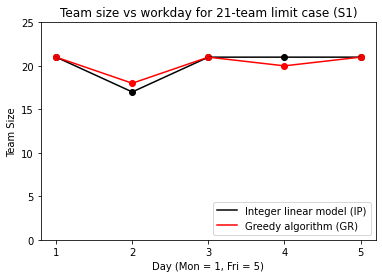

Seed 2:
IP: [20 21 21 18 21]
GR: [21 21 21 17 21]


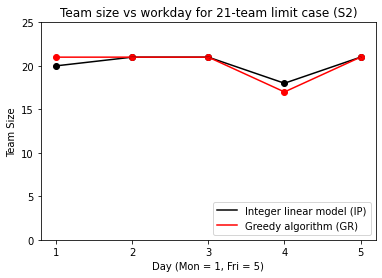

Seed 3:
IP: [21 21 17 21 21]
GR: [21 21 19 19 21]


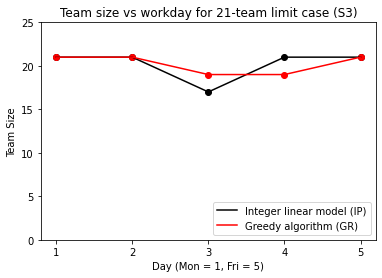

Seed 4:
IP: [21 21 21 18 20]
GR: [21 21 21 21 17]


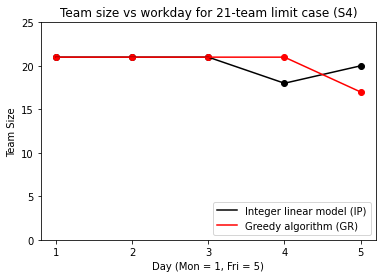

Seed 5:
IP: [17 21 21 21 21]
GR: [17 21 21 21 21]


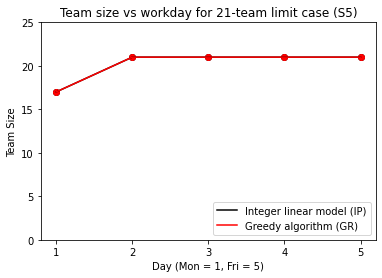

In [50]:
# Plot these comparisons for the 21 team scenario
for r in range(1, 6, 1):    
    print(f'Seed {r}:')
    print('IP:', globals()[f'ip_21m_100t_colsums_{r}'])
    print('GR:', globals()[f'gr_21m_100t_colsums_{r}'])
    plt.scatter(range(1, 6, 1), globals()[f'ip_21m_100t_colsums_{r}'], color='black')
    plt.plot(range(1, 6, 1), globals()[f'ip_21m_100t_colsums_{r}'], color='black', label = 'Integer linear model (IP)')
    plt.scatter(range(1, 6, 1), globals()[f'gr_21m_100t_colsums_{r}'], color='red')
    plt.plot(range(1, 6, 1), globals()[f'gr_21m_100t_colsums_{r}'], color='red', label='Greedy algorithm (GR)')
    plt.xlabel("Day (Mon = 1, Fri = 5)")
    plt.ylabel("Team Size")
    plt.xticks(range(1, 6, 1))
    plt.title(f'Team size vs workday for 21-team limit case (S{r})')
    plt.ylim(0, 25)
    plt.legend(loc='lower right')
    plt.show()


In [51]:
# Save output to csv so that we can do some conditional formatting 
# comparison between results using Excel
cases_to_out = [1, 4, 5]
for case in cases_to_out:
    np.savetxt(f'costs_matrix_large_{case}.csv', globals()[f'costs_matrix_large_{case}'], delimiter=",")
    np.savetxt(f'maint_matrix_ip_{case}.csv', globals()[f'res_21m_matrix_sc_{case}'], delimiter=",")
    np.savetxt(f'maint_matrix_greedy_{case}.csv', globals()[f'gr_solution_sc_{case}'], delimiter=",")

### Additional Work - Not Used in Final Report

#### Genetic Algorithm (GA) Experiment for 7-trubine Problem

592
 The best solution found:                                                                           
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]

 Objective function:
 105.0


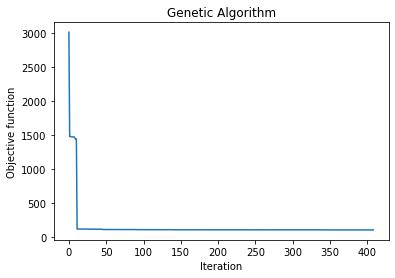

Runtime: 0:00:16.184073 

{'max_num_iteration': None, 'population_size': 300, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': None}

Minimized maintenance cost is €105,000.0
Check on teams:  [2. 1. 2. 0. 2.]
Check on turbine count  7


In [52]:
# pip install geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga

# Calculate maximum possible cost (ignoring constraints)
# This will be used later for input to a penalty calculation in the GA
high_cost = sum(sum(costs_matrix)) 
split = 1
print(high_cost)

# Create the fitness function that we want to optimize
def fitness (x):
    # A penalty term shall be used to include the effect of constraints
    # This will help the algorithm learn how to approach a feasible domain 
    # Initialize as 0 (it will only be applied if constraints are not met)
    penalty = 0
    
    # Reshape the chromosone to the shape of the maintenance matrix
    mains_matrix = np.reshape(x, (int(turbine_count / split), len(days_abb)))
    
    # Calculate the current cost
    #current_cost = sum(sum(mains_matrix * costs_matrix_chunk))   
    current_cost = sum(sum(mains_matrix * costs_matrix)) 
    
    # Check constraints
    # 1) Limit on number of teams available
    chk_team_calc = sum(sum(mains_matrix[:, ]) <= m_teams)
    team_constraint_compliance = chk_team_calc == len(days_abb)
    
    # 2) Each turbine should only be maintained once per week
    chk_turbine_calc = sum(np.sum(mains_matrix, axis = 1) == 1)
    turbine_constraint_compliance = chk_turbine_calc == turbine_count
    
    # Now penalise non-compliance with constraints
    fac_pen = 750 # started at 1000
    if not team_constraint_compliance:    
        penalty = high_cost + fac_pen * (abs(chk_team_calc - len(days_abb)))
    if not turbine_constraint_compliance:
        penalty = high_cost + fac_pen * (abs(chk_turbine_calc - turbine_count))
        
    return(current_cost + penalty)

# default params
algorithm_param = {'max_num_iteration': None,\
                   'population_size':300,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

turbine_count = 7
m_teams = 2
dim = turbine_count * len(days_abb)

model = ga(function = fitness, dimension = dim, variable_type = 'bool', algorithm_parameters = algorithm_param)
now = datetime.now()
model.run()
print('Runtime:', datetime.now() - now, '\n')
print(model.param)

# Print the minimum maintenance cost
print("\nMinimized maintenance cost is €" + "{:,}".format(model.output_dict['function'] * 1000))

solution = np.reshape(model.output_dict['variable'], (int(turbine_count / split), len(days_abb)))

# 1) Limit on number of teams available
print('Check on teams: ', sum(solution[:, ]))
    
# 2) Each turbine should only be maintained once per week
print('Check on turbine count ', sum(np.sum(solution, axis = 1) == 1))

GA finds the optimised low cost for the 7-turbine problem.  But a more complicated approach would be required to solve the large scale problem.  We would likely need to be change the chromosome formulation and seed the population with feasible solutions.  For these reasons, the greedy algorithm was deemed to be a better fit for the project scope and timescale.